# Event Study (Dynamic DiD) with `pymc` models

This notebook demonstrates how to use CausalPy's `EventStudy` class to estimate **dynamic treatment effects** over event time. This is also known as a "dynamic {term}`difference in differences`" analysis. The {term}`event study` is a powerful tool for:
1. Examining **pre-treatment trends** (placebo checks for {term}`parallel trends assumption`)
2. Estimating how **treatment effects evolve over time** after treatment
3. Visualizing the full **time path of causal effects**

## Background: What is an Event Study?

An event study analyzes panel data where some units receive treatment at a specific time. Unlike standard difference-in-differences which estimates a single average treatment effect, event studies estimate **separate coefficients for each time period relative to treatment**.

The key concept is **event time** (or relative time):

$$E_{it} = t - G_i$$

where $t$ is the calendar time and $G_i$ is the treatment time for unit $i$.

The model estimates {cite:t}`sun2021estimating`:

$$Y_{it} = \alpha_i + \lambda_t + \sum_{k \neq k_0} \beta_k \cdot \mathbf{1}\{E_{it} = k\} + \varepsilon_{it}$$

where:
- $\alpha_i$ are unit fixed effects
- $\lambda_t$ are time fixed effects
- $\beta_k$ are the dynamic treatment effects at event time $k$
- $k_0$ is the reference (omitted) period, typically $k=-1$

**Interpretation:**
- $\beta_k$ for $k < 0$ (pre-treatment): Should be near zero if parallel trends hold
- $\beta_k$ for $k \geq 0$ (post-treatment): Measure the causal effect at each period after treatment

:::{warning}
This implementation uses a standard two-way fixed effects (TWFE) estimator, which requires **simultaneous treatment timing** - all treated units must receive treatment at the same time. Staggered adoption designs (where different units are treated at different times) can produce biased estimates when treatment effects vary across cohorts {footcite:t}`sun2021estimating`.
:::


In [1]:
import textwrap

import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

import causalpy as cp
from causalpy.data.simulate_data import generate_event_study_data

In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
seed = 42
# Set arviz style to override seaborn's default
az.style.use("arviz-darkgrid")

## Generate Simulated Data

We'll create synthetic panel data with:
- 30 units (half treated, half control)
- 20 time periods
- Treatment occurring at time 10
- Known treatment effects: zero pre-treatment, gradually increasing post-treatment


In [3]:
# Define known treatment effects for simulation
# Pre-treatment: no effect (parallel trends)
# Post-treatment: effect increases over time
true_effects = {
    -5: 0.0,
    -4: 0.0,
    -3: 0.0,
    -2: 0.0,
    -1: 0.0,  # Pre-treatment
    0: 0.5,
    1: 0.7,
    2: 0.9,
    3: 1.0,
    4: 1.0,
    5: 1.0,  # Post-treatment
}

df = generate_event_study_data(
    n_units=30,
    n_time=20,
    treatment_time=10,
    treated_fraction=0.5,
    event_window=(-5, 5),
    treatment_effects=true_effects,
    unit_fe_sigma=1.0,
    time_fe_sigma=0.3,
    noise_sigma=0.2,
    seed=seed,
)

print(f"Data shape: {df.shape}")
df.head(10)

Data shape: (600, 5)


,unit,time,y,treat_time,treated
0,0,0,0.381019,10.0,1
1,0,1,0.975381,10.0,1
2,0,2,0.357281,10.0,1
3,0,3,0.301736,10.0,1
4,0,4,0.949678,10.0,1
5,0,5,0.316717,10.0,1
6,0,6,0.391530,10.0,1
7,0,7,-0.153029,10.0,1
8,0,8,0.164511,10.0,1
9,0,9,0.750882,10.0,1


Let's visualize the data to understand its structure:


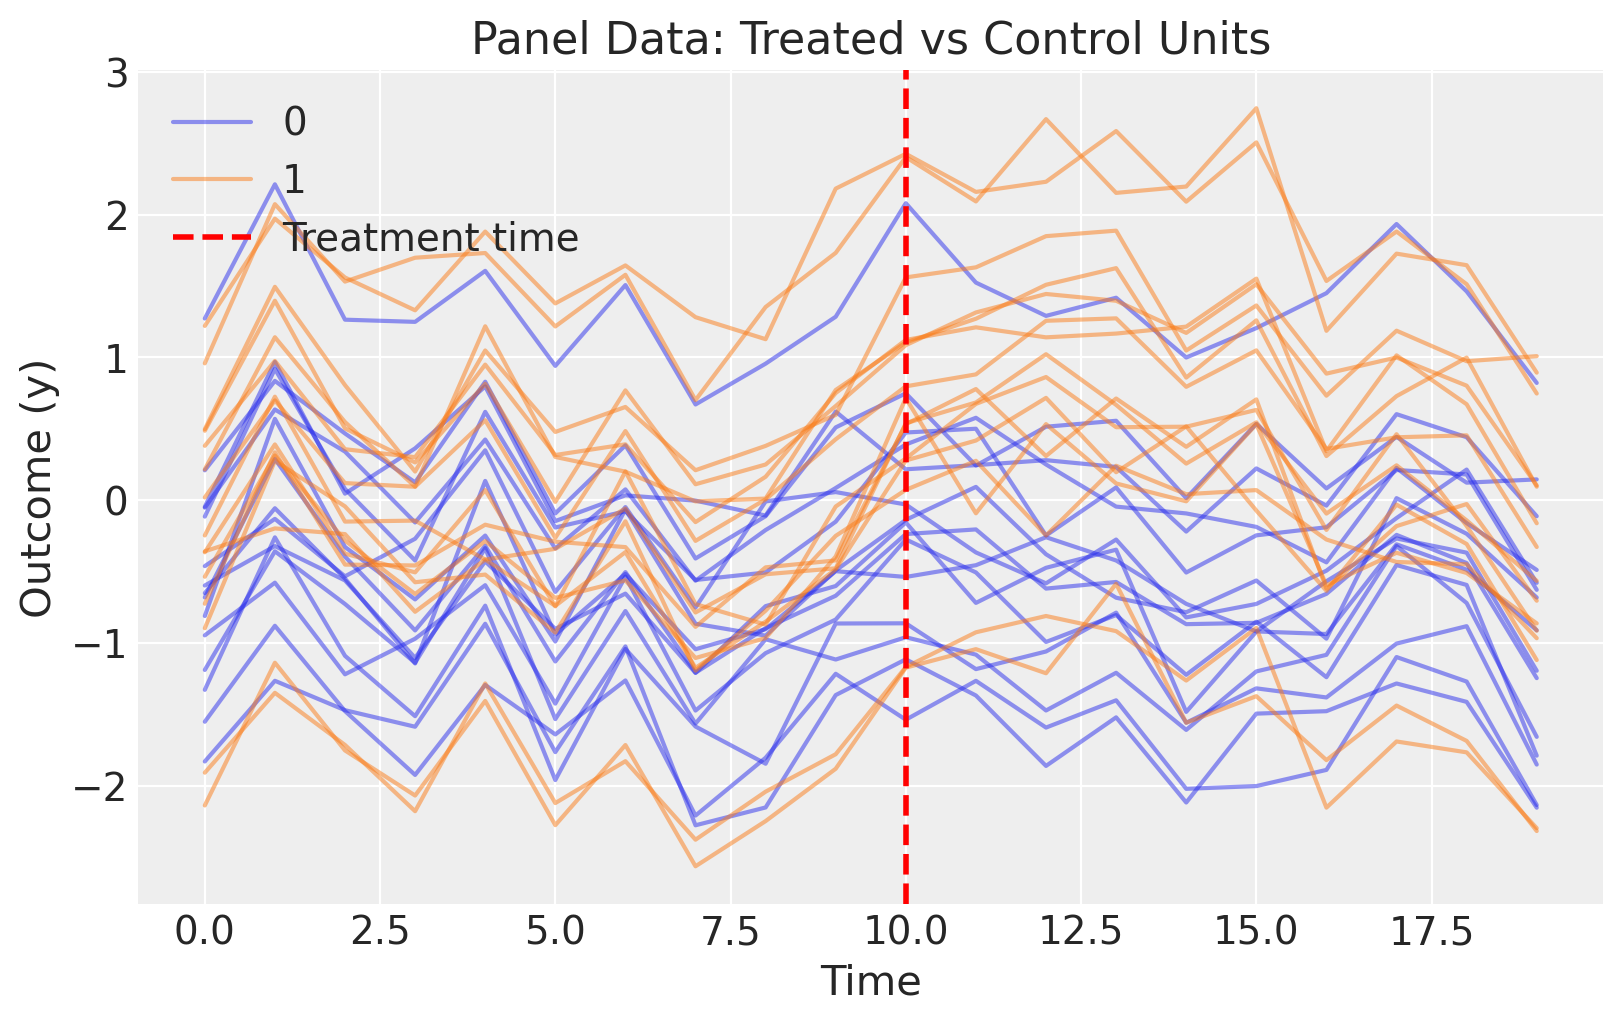

In [4]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.lineplot(
    data=df,
    x="time",
    y="y",
    hue="treated",
    units="unit",
    estimator=None,
    alpha=0.5,
    ax=ax,
)
ax.axvline(x=10, color="red", linestyle="--", linewidth=2, label="Treatment time")
ax.set(
    xlabel="Time", ylabel="Outcome (y)", title="Panel Data: Treated vs Control Units"
)
ax.legend(loc="upper left")
plt.show()

## Event Study Analysis #1

Now we use CausalPy's `EventStudy` class to estimate the dynamic treatment effects.

The `formula` parameter uses patsy syntax to specify the model structure:
- `y ~ C(unit) + C(time)` specifies the outcome variable `y` with unit fixed effects ($\alpha_i$) and time fixed effects ($\lambda_t$)
- `C(column)` indicates a categorical variable that should be converted to dummy variables

**What about the $\beta_k$ coefficients?** These are the event-time dummies - the key parameters we want to estimate. They capture the treatment effect at each period *relative to treatment* (i.e., at each event time $k$). The class automatically constructs these based on:
- The `event_window` parameter (e.g., `(-5, 5)` means $k \in \{-5, -4, ..., 0, ..., 5\}$)
- The `reference_event_time` parameter (e.g., `-1` is omitted as the baseline)

So the formula specifies the "structural" part of the model ($\alpha_i + \lambda_t$), while the event-time dummies ($\sum_{k \neq k_0} \beta_k \cdot \mathbf{1}\{E_{it} = k\}$) are added automatically.

:::{note}
The `random_seed` keyword argument for the PyMC sampler is not necessary. We use it here so that the results are reproducible.
:::

In [5]:
result = cp.EventStudy(
    df,
    formula="y ~ C(unit) + C(time)",  # Outcome with unit and time fixed effects
    unit_col="unit",
    time_col="time",
    treat_time_col="treat_time",
    event_window=(-5, 5),
    reference_event_time=-1,  # One period before treatment as reference
    model=cp.pymc_models.LinearRegression(sample_kwargs={"random_seed": seed}),
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [beta, y_hat, y_hat_sigma]
Sampling: [y_hat]


### Visualize the Results

The event study plot shows the estimated treatment effects ($\beta_k$) at each event time, with credible intervals. This is the key diagnostic plot for event studies.


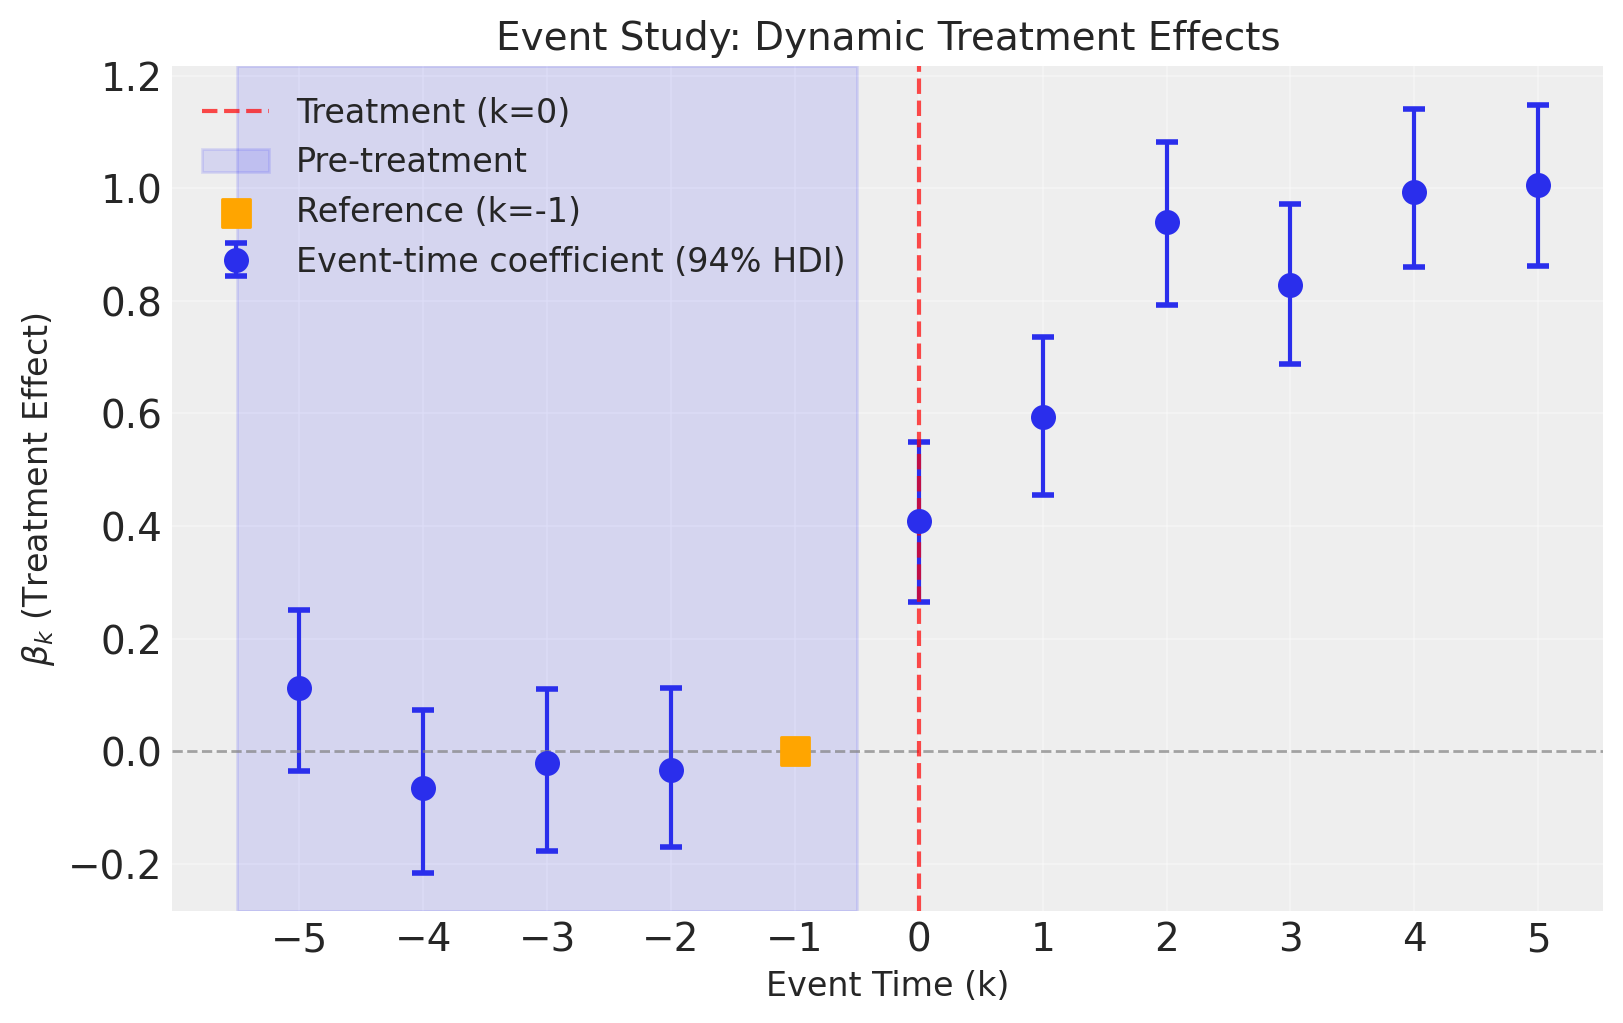

In [6]:
fig, ax = result.plot(figsize=(8, 5))

**Interpreting the Plot:**

1. **Pre-treatment periods** ($k < 0$, blue shaded): The coefficients should be close to zero. This is a key test of the parallel trends assumption. If we see significant pre-trends, our causal estimates may be biased.

2. **Reference period** ($k = -1$, orange square): This is fixed at zero by construction. All other coefficients are interpreted relative to this period.

3. **Post-treatment periods** ($k \geq 0$): These show how the treatment effect evolves over time. In our simulated data, we see the effect starts at about 0.5 and increases to around 1.0.

4. **Credible intervals**: The error bars show 94% highest density intervals. When these don't include zero for post-treatment periods, we have strong evidence of a treatment effect.

:::{tip}
The plot can be customized with optional parameters:
- `figsize=(width, height)` to change the figure size
- `hdi_prob=0.89` to change the credible interval (e.g., 89% instead of 94%)

Example: `result.plot(figsize=(12, 8), hdi_prob=0.89)`
:::


### Summary Statistics


In [7]:
result.summary()

==================================Event Study===================================
Formula: y ~ C(unit) + C(time)
Event window: (-5, 5)
Reference event time: -1

Event-time coefficients (beta_k):
------------------------------------------------------------
  Event Time       Mean         SD     HDI 3%    HDI 97%
------------------------------------------------------------
          -5       0.11      0.077     -0.035       0.25
          -4     -0.065      0.077      -0.22      0.073
          -3     -0.021      0.078      -0.18       0.11
          -2     -0.032      0.075      -0.17       0.11
          -1    0 (ref)          -          -          -
           0       0.41      0.076       0.26       0.55
           1       0.59      0.075       0.45       0.74
           2       0.94      0.078       0.79        1.1
           3       0.83      0.075       0.69       0.97
           4       0.99      0.075       0.86        1.1
           5          1      0.076       0.86        1.1


### Effect Summary

The `effect_summary()` method provides a decision-ready summary with both a table and prose description. It automatically includes a **parallel trends check** that examines whether pre-treatment coefficients are consistent with the identifying assumption:


In [8]:
effect = result.effect_summary()
wrapped = textwrap.fill(effect.text, width=75)
print(wrapped)

Event study analysis with 11 time periods (k=-5 to k=5), reference period
k=-1. Pre-treatment coefficients (k<0) are consistent with the parallel
trends assumption (all 95% HDIs include zero). Post-treatment effects (k≥0)
show treatment impact ranging from 0.41 to 1.01.


In [9]:
effect.table

,event_time,mean,std,hdi_3%,hdi_98%,is_reference
0,-5,0.113427,0.076994,-0.035227,0.263490,False
1,-4,-0.064592,0.076905,-0.223268,0.077255,False
2,-3,-0.021091,0.077551,-0.176982,0.122292,False
3,-2,-0.032195,0.074954,-0.180698,0.112547,False
4,-1,0.000000,0.000000,0.000000,0.000000,True
5,0,0.409094,0.075700,0.264175,0.559484,False
6,1,0.593974,0.075284,0.442126,0.735045,False
7,2,0.940384,0.077661,0.791473,1.092842,False
8,3,0.827706,0.075419,0.679464,0.972220,False
9,4,0.992739,0.075394,0.848039,1.139731,False


:::{tip}
You can disable the parallel trends check in the prose by passing `include_pretrend_check=False`:
```python
result.effect_summary(include_pretrend_check=False)
```
:::

We can also get the event-time coefficients as a DataFrame directly like this:


In [10]:
summary_df = result.get_event_time_summary()
summary_df

,event_time,mean,std,hdi_3%,hdi_97%,is_reference
0,-5,0.113427,0.076994,-0.035227,0.251823,False
1,-4,-0.064592,0.076905,-0.215547,0.073316,False
2,-3,-0.021091,0.077551,-0.177766,0.111183,False
3,-2,-0.032195,0.074954,-0.169954,0.112547,False
4,-1,0.000000,0.000000,0.000000,0.000000,True
5,0,0.409094,0.075700,0.264636,0.548505,False
6,1,0.593974,0.075284,0.454389,0.735734,False
7,2,0.940384,0.077661,0.792238,1.081568,False
8,3,0.827706,0.075419,0.688432,0.971350,False
9,4,0.992739,0.075394,0.860349,1.140122,False


### Compare Estimated vs True Effects

Since we simulated the data with known treatment effects, we can compare our estimates to the true values. We would not be able to do this with real-world data where the ground truth is unknown.


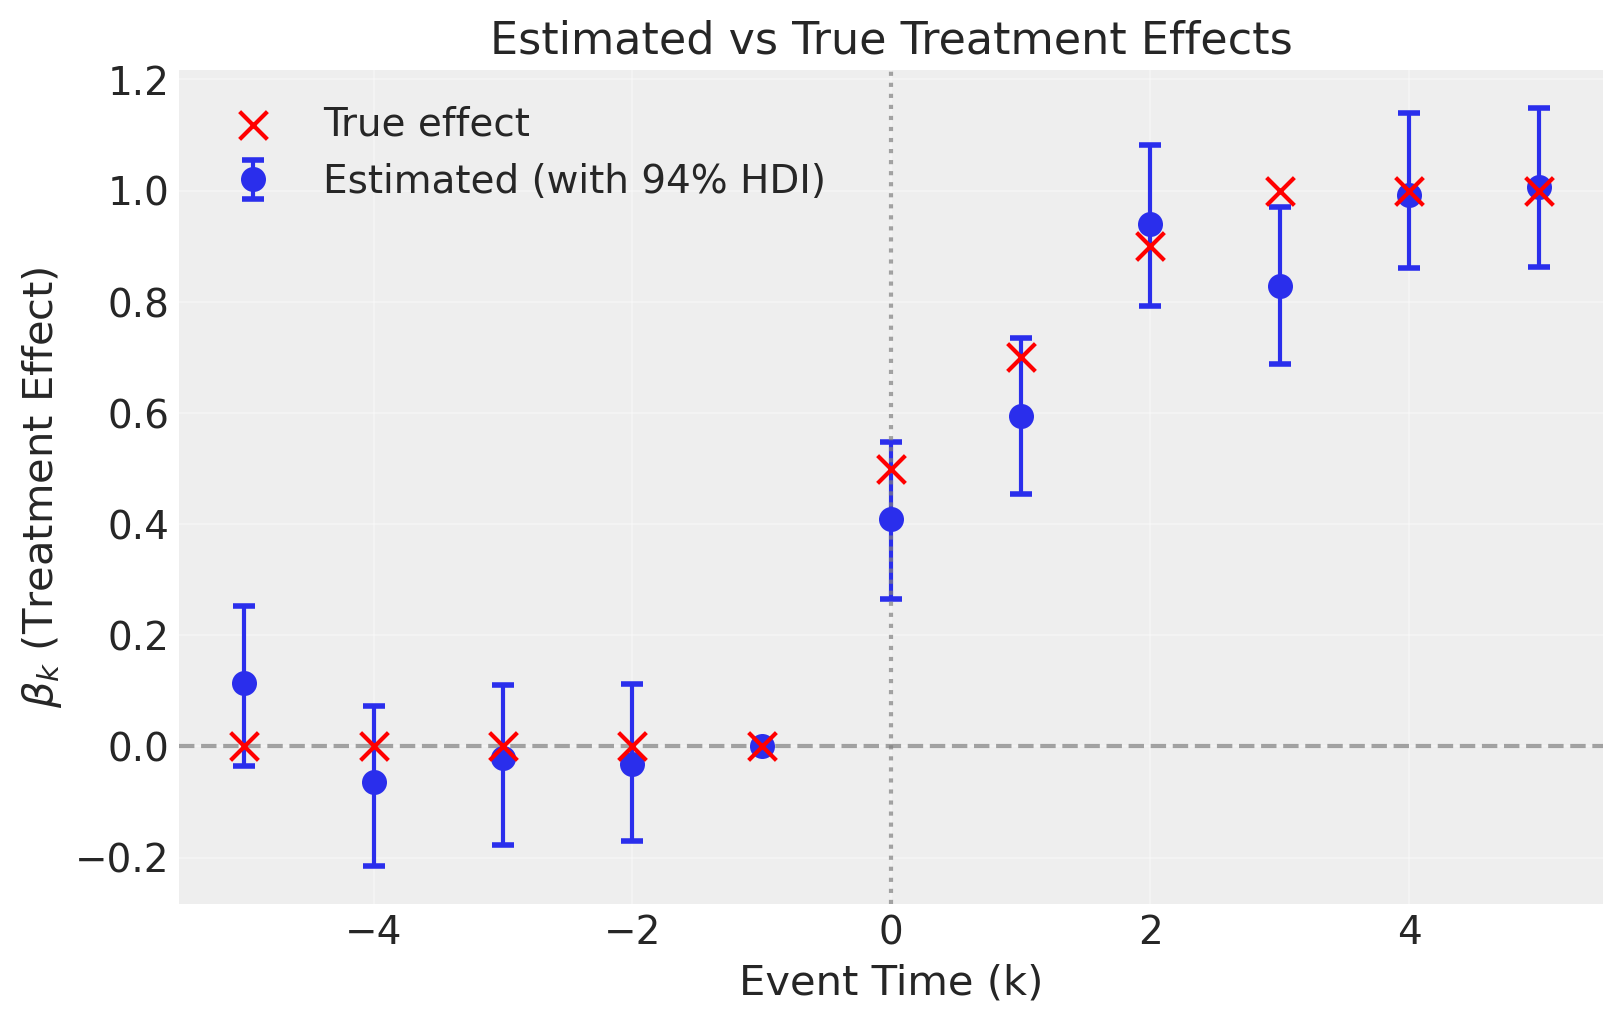

In [11]:
fig, ax = plt.subplots(figsize=(8, 5))

# Plot estimated effects
event_times = summary_df["event_time"].values
estimated_means = summary_df["mean"].values
lower = summary_df["hdi_3%"].values
upper = summary_df["hdi_97%"].values

ax.errorbar(
    event_times,
    estimated_means,
    yerr=[estimated_means - lower, upper - estimated_means],
    fmt="o",
    capsize=4,
    capthick=2,
    markersize=8,
    color="C0",
    label="Estimated (with 94% HDI)",
)

# Plot true effects (relative to k=-1 reference)
# Since k=-1 is our reference, we need to subtract true_effects[-1] from all
true_effects_relative = {k: v - true_effects[-1] for k, v in true_effects.items()}
true_k = list(true_effects_relative.keys())
true_beta = list(true_effects_relative.values())
ax.scatter(
    true_k, true_beta, marker="x", s=100, color="red", zorder=5, label="True effect"
)

ax.axhline(y=0, color="gray", linestyle="--", alpha=0.7)
ax.axvline(x=0, color="gray", linestyle=":", alpha=0.7)
ax.set_xlabel("Event Time (k)")
ax.set_ylabel(r"$\beta_k$ (Treatment Effect)")
ax.set_title("Estimated vs True Treatment Effects")
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

The estimated effects closely track the true effects, demonstrating that the event study correctly recovers the dynamic treatment effects.


## Event Study Analysis #2

Now we'll run an event study analysis but without a time fixed effect.

In [12]:
result2 = cp.EventStudy(
    df,
    formula="y ~ C(unit)",  # Outcome with unit fixed effects, no time fixed effects
    unit_col="unit",
    time_col="time",
    treat_time_col="treat_time",
    event_window=(-5, 5),
    reference_event_time=-1,  # One period before treatment as reference
    model=cp.pymc_models.LinearRegression(sample_kwargs={"random_seed": seed}),
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [beta, y_hat, y_hat_sigma]
Sampling: [y_hat]


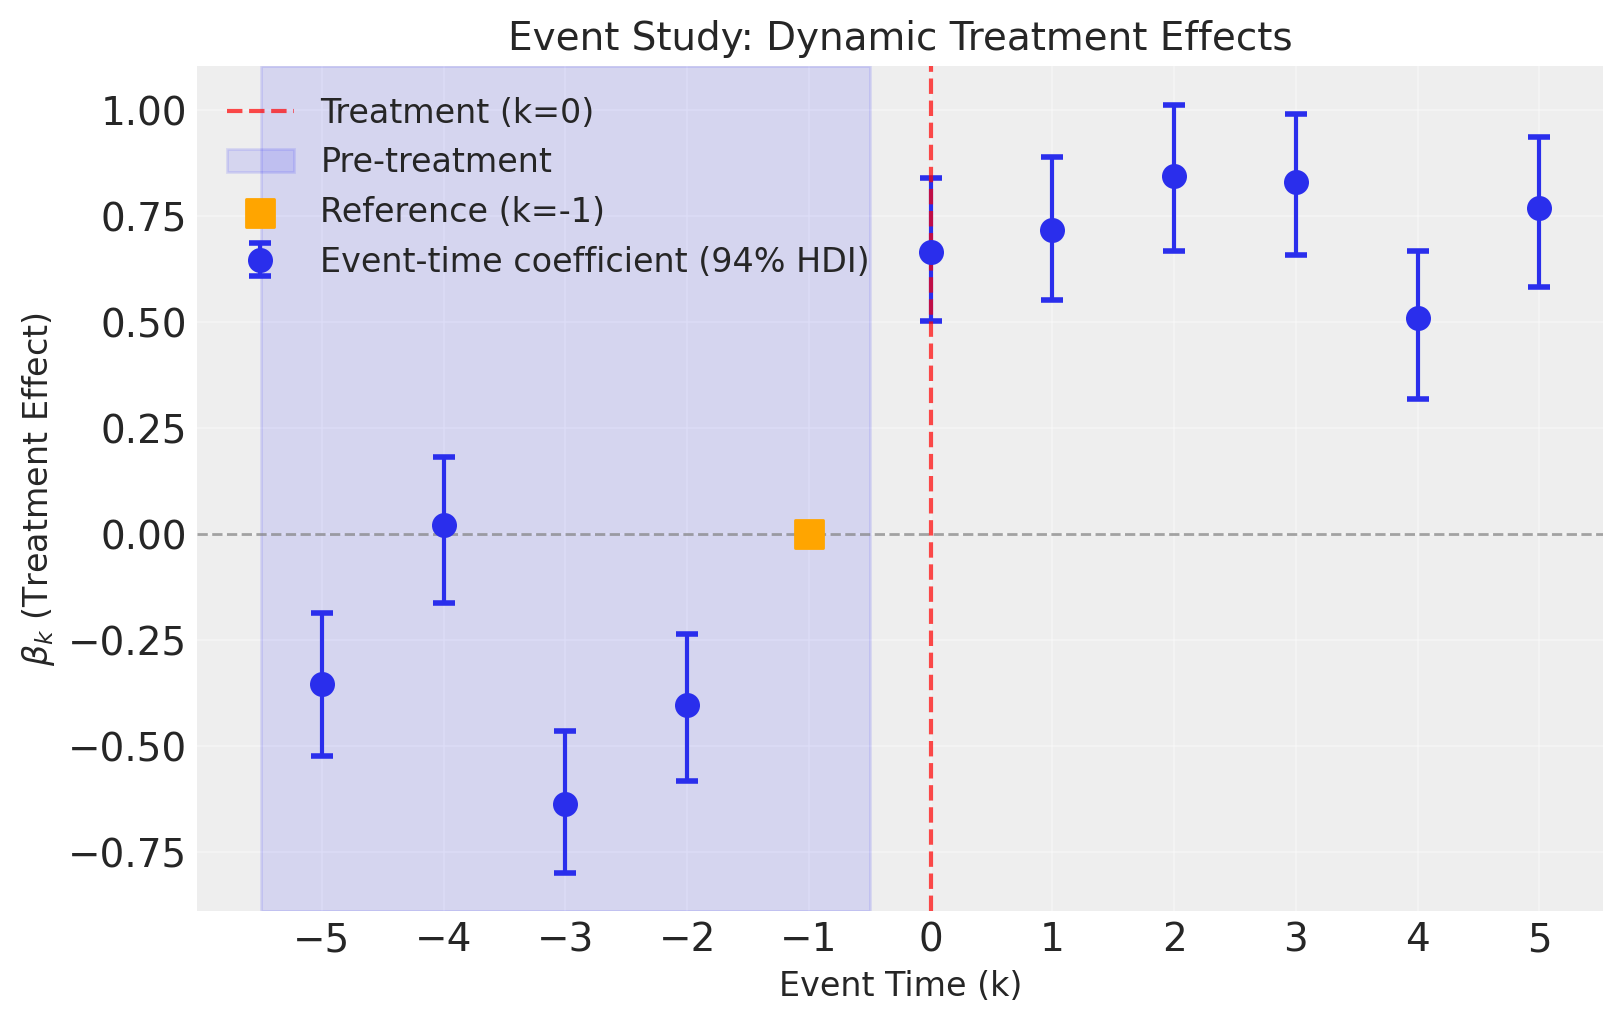

In [13]:
fig, ax = result2.plot(figsize=(8, 5))

In [14]:
summary_df = result2.get_event_time_summary()
summary_df

,event_time,mean,std,hdi_3%,hdi_97%,is_reference
0,-5,-0.353136,0.090493,-0.522287,-0.186003,False
1,-4,0.021606,0.091856,-0.161145,0.181621,False
2,-3,-0.635135,0.089622,-0.797790,-0.462520,False
3,-2,-0.403374,0.092969,-0.582083,-0.234025,False
4,-1,0.000000,0.000000,0.000000,0.000000,True
5,0,0.666587,0.091566,0.503798,0.839579,False
6,1,0.716158,0.091080,0.552381,0.888947,False
7,2,0.844532,0.093367,0.667764,1.012533,False
8,3,0.829304,0.089390,0.659251,0.989613,False
9,4,0.508772,0.091841,0.319907,0.667985,False


We can see that not including time fixed effects means that we are unable to account for time-based shocks that affect all units identically. The consequence of this is that our causal estimates (the dynamic treatment effects) are now biased. This is most noticable with the pre-intervention placebo checks, where we see meaningful deviations from zero effect _before_ the intervention.

## Event Study Analysis #3: With Time-Varying Predictors

In real-world applications, outcomes often depend on time-varying covariates beyond the treatment itself. For example, sales might be affected by temperature, economic indicators, or seasonal factors.

The `generate_event_study_data` function supports generating **time-varying predictors** via AR(1) processes. These predictors:
- Vary smoothly over time (controlled by the `ar_phi` persistence parameter)
- Are the same for all units at a given time period
- Contribute to the outcome through user-specified coefficients

The data generating process becomes:

$$Y_{it} = \alpha_i + \lambda_t + \sum_j \gamma_j X_{jt} + \sum_{k \neq k_0} \beta_k \cdot \mathbf{1}\{E_{it} = k\} + \varepsilon_{it}$$

where $X_{jt}$ are the time-varying predictors and $\gamma_j$ are their true coefficients.


In [15]:
# Generate data with two time-varying predictors
# - temperature: positive effect on outcome (coefficient = 0.3)
# - humidity: negative effect on outcome (coefficient = -0.2)
df_predictors = generate_event_study_data(
    n_units=30,
    n_time=20,
    treatment_time=10,
    treated_fraction=0.5,
    event_window=(-5, 5),
    treatment_effects=true_effects,
    unit_fe_sigma=1.0,
    time_fe_sigma=0.3,
    noise_sigma=0.2,
    predictor_effects={"temperature": 0.3, "humidity": -0.2},
    ar_phi=0.9,  # High persistence for smooth variation
    ar_scale=1.0,
    seed=seed,
)

print(f"Data shape: {df_predictors.shape}")
print(f"Columns: {df_predictors.columns.tolist()}")
df_predictors.head(10)

Data shape: (600, 7)
Columns: ['unit', 'time', 'y', 'treat_time', 'treated', 'temperature', 'humidity']


,unit,time,y,treat_time,treated,temperature,humidity
0,0,0,0.210250,10.0,1,0.000000,0.000000
1,0,1,1.381300,10.0,1,0.324084,-0.645120
2,0,2,0.527901,10.0,1,-0.093407,-0.219212
3,0,3,-0.123316,10.0,1,-0.760988,1.340746
4,0,4,0.346934,10.0,1,-0.073213,1.170845
5,0,5,-0.169220,10.0,1,0.965108,2.618404
6,0,6,1.073551,10.0,1,1.799877,-0.263181
7,0,7,-0.266696,10.0,1,0.780672,0.585039
8,0,8,0.152784,10.0,1,0.393392,0.613582
9,0,9,0.762935,10.0,1,0.685317,0.253217


/var/folders/r0/nf1kgxsx6zx3rw16xc3wnnzr0000gn/T/ipykernel_57340/448970239.py:20: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


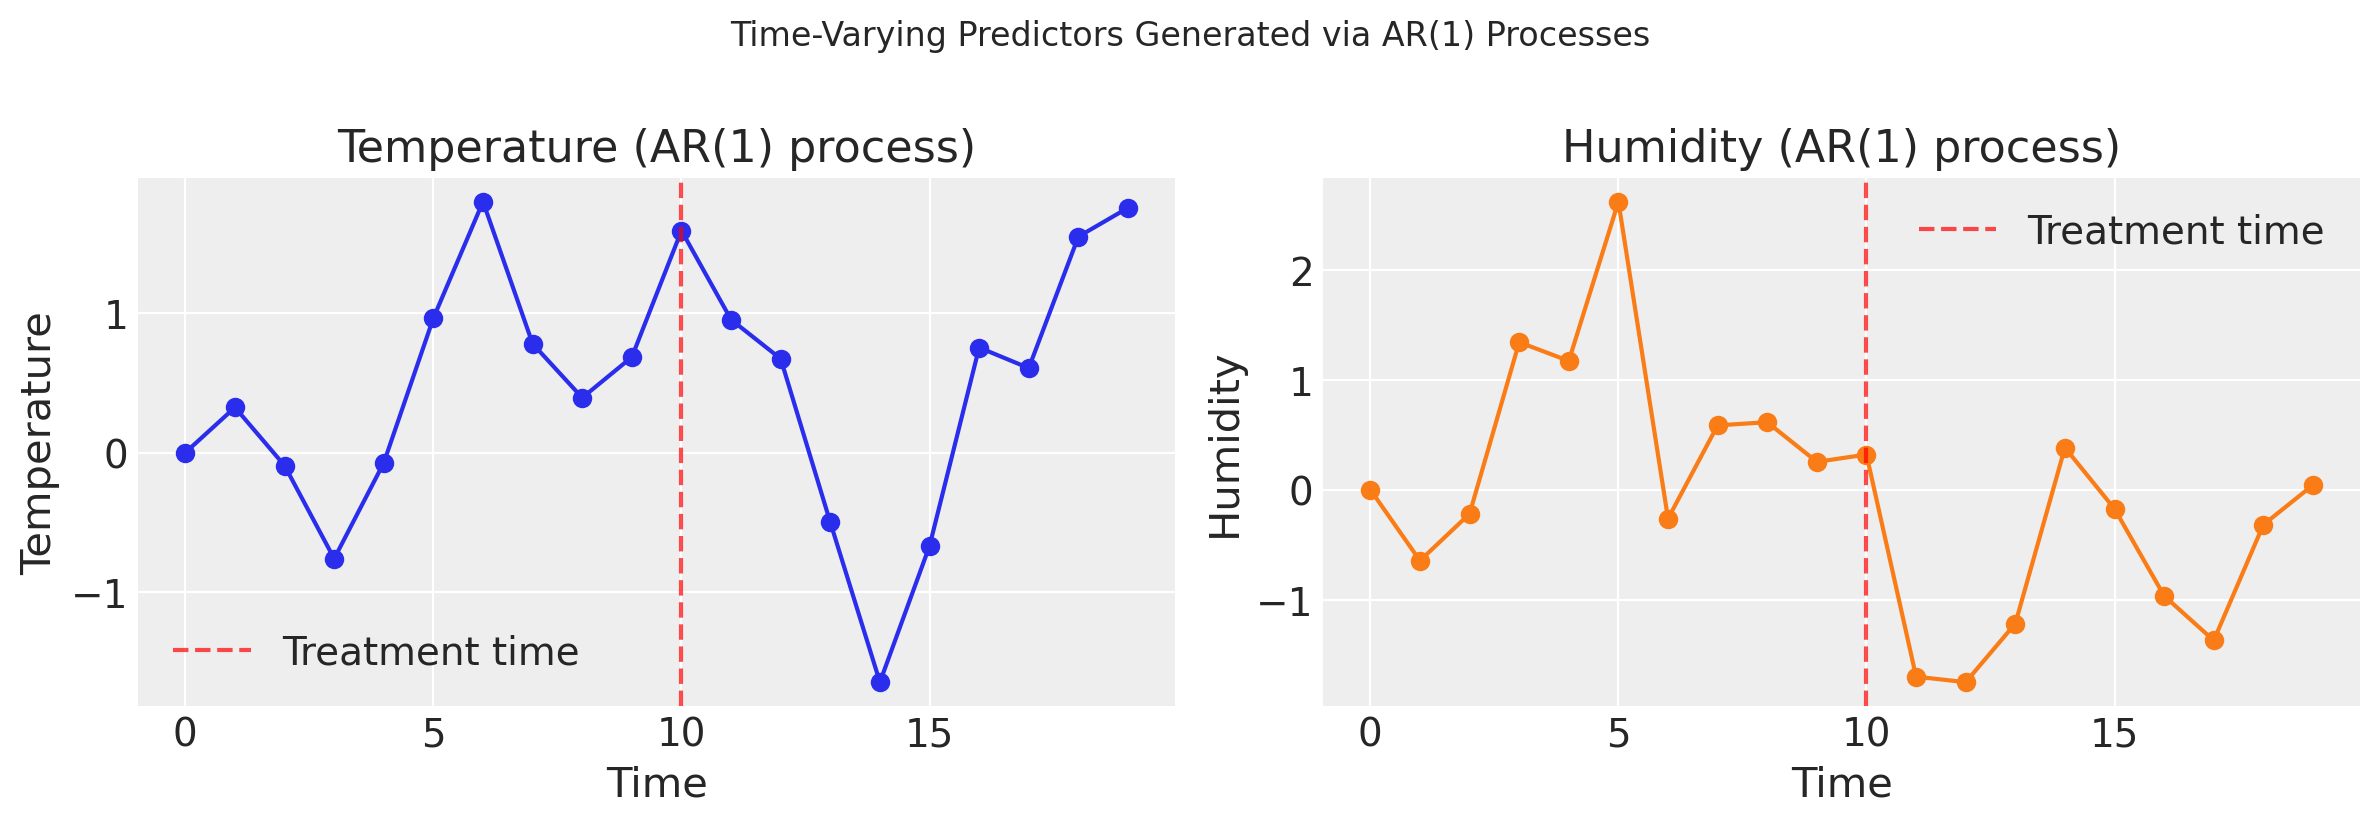

In [16]:
# Visualize the time-varying predictors
# Since predictors are the same for all units at each time, we just need one unit's data
predictor_data = df_predictors[df_predictors["unit"] == 0][
    ["time", "temperature", "humidity"]
]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(predictor_data["time"], predictor_data["temperature"], marker="o")
axes[0].axvline(x=10, color="red", linestyle="--", alpha=0.7, label="Treatment time")
axes[0].set(xlabel="Time", ylabel="Temperature", title="Temperature (AR(1) process)")
axes[0].legend()

axes[1].plot(predictor_data["time"], predictor_data["humidity"], marker="o", color="C1")
axes[1].axvline(x=10, color="red", linestyle="--", alpha=0.7, label="Treatment time")
axes[1].set(xlabel="Time", ylabel="Humidity", title="Humidity (AR(1) process)")
axes[1].legend()

plt.suptitle("Time-Varying Predictors Generated via AR(1) Processes", y=1.02)
plt.tight_layout()
plt.show()

Now we run the event study, **including the predictors in the formula**. This allows the model to control for the time-varying confounders:


In [17]:
result3 = cp.EventStudy(
    df_predictors,
    formula="y ~ temperature + humidity + C(unit) + C(time)",
    unit_col="unit",
    time_col="time",
    treat_time_col="treat_time",
    event_window=(-5, 5),
    reference_event_time=-1,
    model=cp.pymc_models.LinearRegression(sample_kwargs={"random_seed": seed}),
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [beta, y_hat, y_hat_sigma]
Sampling: [y_hat]


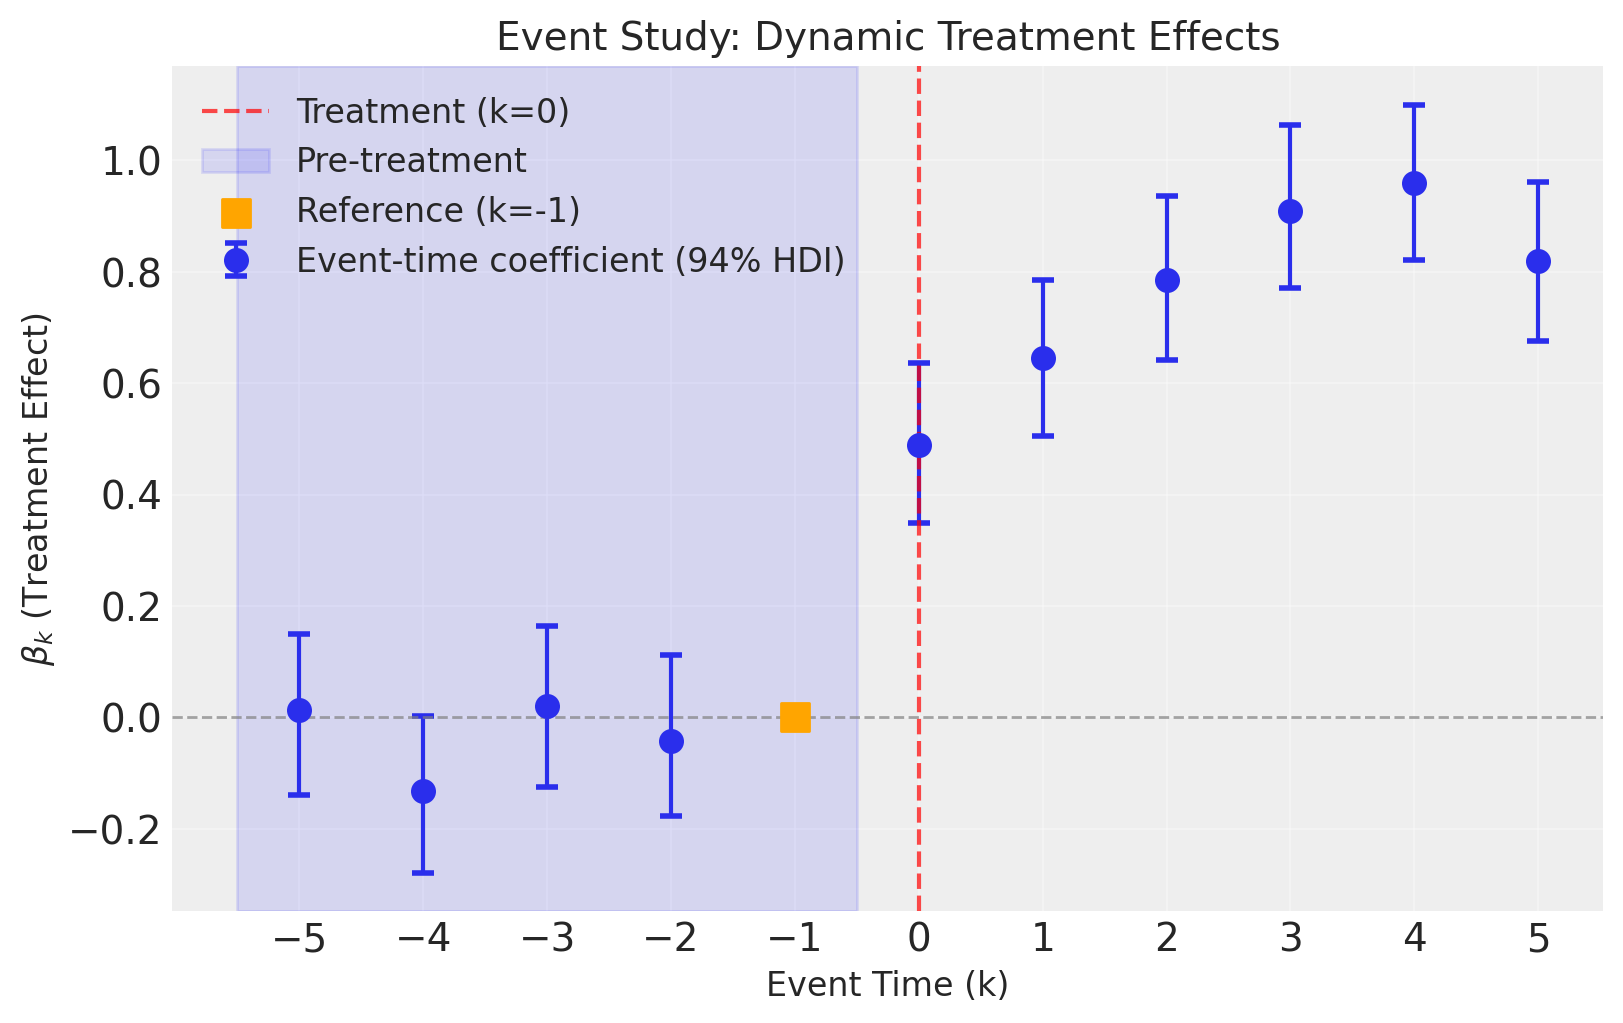

In [18]:
fig, ax = result3.plot(figsize=(8, 5))

The event study correctly recovers the dynamic treatment effects even in the presence of time-varying predictors. We can also verify that the model estimates the predictor coefficients close to their true values (temperature: 0.3, humidity: -0.2):


## Key Takeaways

1. **Event studies** provide richer information than standard DiD by estimating treatment effects at each event time.

2. **Pre-trend analysis** is crucial: the `effect_summary()` method automatically checks whether pre-treatment coefficients ($k < 0$) are consistent with the parallel trends assumption.

3. **Dynamic effects** can reveal how treatment impacts evolve over time—whether effects are immediate, gradual, or temporary.

4. **The reference period** ($k_0$, typically -1) is normalized to zero. All coefficients are interpreted relative to this period.

5. **Bayesian estimation** provides full posterior distributions for each coefficient, enabling probabilistic statements about effect sizes.

6. **Time-varying predictors** can be included in the model formula to control for confounders. The `generate_event_study_data` function supports generating AR(1) predictors with user-specified coefficients for realistic simulations.


## References 

:::{bibliography}
:filter: docname in docnames
:::